### 시황별 어떤 팩터가 좋은지 확인

In [25]:
from econ_regime.econ_regime import business_cycle, asset_indicators
from price.macro_info import get_econ_info
from strategy.factors.beta import *
from strategy.optimize.cross_sectional import *
from backtest.metric import *

import pandas as pd
import numpy as np
import statsmodels.api as sm
import bs4 as bs
import requests
import datetime as dt
import pickle5 as pickle

### 주식 베타

In [17]:
equity_df = pd.read_csv('../quant/equity_universe.csv', index_col=0)
equity_df.index = pd.to_datetime(equity_df.index)

In [18]:
equity_df = equity_df.loc['2011':,].dropna(axis=1)
equity_df

,A,AAL,AAP,AAPL,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-03,27.163610,10.040195,60.552662,10.033263,28.549282,17.639103,9.832222,38.638706,31.290001,28.432861,...,73.060722,12.822729,77.632805,15.788007,46.502182,32.227661,28.031958,48.627453,38.200001,21.050661
2011-01-04,26.910648,10.011914,57.538910,10.085626,28.233181,17.805092,9.771111,38.384243,31.510000,28.110697,...,71.834747,12.686455,80.054596,15.855021,46.720490,31.869568,27.603678,47.981678,37.840000,20.707764
2011-01-05,26.852272,10.464432,57.612873,10.168124,28.665747,17.805092,9.785556,38.392178,32.220001,28.170630,...,72.832153,13.082301,81.087448,15.761208,46.595737,32.172558,27.735012,48.017067,37.799999,20.824848
2011-01-06,26.904169,10.596415,55.717705,10.159907,28.998491,17.768208,9.653333,38.535332,32.270000,28.327969,...,73.039963,12.991453,81.678627,15.747799,46.895157,31.988941,27.929159,46.530907,37.480000,20.766296
2011-01-07,26.994974,10.747252,57.206089,10.232668,29.056715,17.841972,9.580000,38.598942,32.040001,28.163143,...,72.915298,13.348357,84.570541,15.888525,47.150887,31.860401,28.277491,46.522053,37.599998,20.548853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,156.562347,18.260000,224.063019,175.262802,127.924423,136.246506,43.480000,396.261078,569.619995,169.451675,...,232.187408,36.561798,88.879997,64.804298,58.691692,54.536747,132.787628,122.040504,582.409973,60.688782
2021-12-27,157.494980,18.170000,228.281143,179.289444,130.265030,138.498337,43.930000,408.070984,577.679993,172.209473,...,234.740433,37.526936,87.580002,65.008598,59.528496,55.048363,135.407288,123.061127,606.330017,61.321358
2021-12-28,157.931503,18.540001,229.854492,178.255432,130.719345,137.529068,44.270000,408.011993,569.359985,171.139740,...,234.406555,37.716183,86.459999,65.786911,59.336128,55.127079,135.377838,123.446266,597.320007,61.418682


In [19]:
benchmark = pd.DataFrame({'SPY': yf.download('SPY', start=equity_df.iloc[0].name, end=equity_df.iloc[-1].name)['Adj Close']})
benchmark

[*********************100%***********************]  1 of 1 completed


,SPY
Date,
2011-01-03,101.109306
2011-01-04,101.053612
2011-01-05,101.578842
2011-01-06,101.379898
2011-01-07,101.180939
...,...
2021-12-22,460.223633
2021-12-23,463.087189
2021-12-27,469.640869


In [20]:
equity_universe_df = pd.concat([equity_df, benchmark], axis=1).dropna()

In [21]:
monthly_index = equity_universe_df.resample('M').last().index
monthly_index = monthly_index[12:]

In [22]:
df = equity_universe_df.loc[:'2011-12-31', :]
df

,A,AAL,AAP,AAPL,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION,SPY
2011-01-03,27.163610,10.040195,60.552662,10.033263,28.549282,17.639103,9.832222,38.638706,31.290001,28.432861,...,12.822729,77.632805,15.788007,46.502182,32.227661,28.031958,48.627453,38.200001,21.050661,101.109306
2011-01-04,26.910648,10.011914,57.538910,10.085626,28.233181,17.805092,9.771111,38.384243,31.510000,28.110697,...,12.686455,80.054596,15.855021,46.720490,31.869568,27.603678,47.981678,37.840000,20.707764,101.053612
2011-01-05,26.852272,10.464432,57.612873,10.168124,28.665747,17.805092,9.785556,38.392178,32.220001,28.170630,...,13.082301,81.087448,15.761208,46.595737,32.172558,27.735012,48.017067,37.799999,20.824848,101.578842
2011-01-06,26.904169,10.596415,55.717705,10.159907,28.998491,17.768208,9.653333,38.535332,32.270000,28.327969,...,12.991453,81.678627,15.747799,46.895157,31.988941,27.929159,46.530907,37.480000,20.766296,101.379898
2011-01-07,26.994974,10.747252,57.206089,10.232668,29.056715,17.841972,9.580000,38.598942,32.040001,28.163143,...,13.348357,84.570541,15.888525,47.150887,31.860401,28.277491,46.522053,37.599998,20.548853,101.180939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-23,22.934694,5.298207,65.190269,12.278773,31.500214,21.440283,12.500000,42.907688,28.290001,27.872917,...,12.153739,82.537621,18.994987,54.418274,32.857399,34.394424,47.070530,36.520000,13.686030,102.694283
2011-12-27,22.863352,5.090804,65.811996,12.376197,31.744347,21.520660,12.550000,42.940136,28.500000,28.003786,...,12.280827,85.186310,19.288298,54.456566,32.765171,34.551754,47.132454,36.590000,13.744698,102.775536
2011-12-28,22.123940,4.892828,65.199509,12.257767,31.003559,21.367561,12.386667,42.883350,28.020000,27.403364,...,12.361092,81.952347,19.176558,53.754166,32.187920,34.365292,47.026291,35.700001,13.484888,101.426727
2011-12-29,22.740112,4.930538,65.283035,12.333268,31.424454,21.558926,12.440000,43.678379,28.309999,27.595797,...,12.628647,82.792725,19.351145,54.450188,32.603546,34.714886,47.273979,35.980000,13.811742,102.474915


In [23]:
beta_signal = Beta(equity_universe=equity_universe_df, benchmark_ticker='SPY').beta()
beta_signal


,A,AAL,AAP,AAPL,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
2012-01-31,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-02-29,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-03-31,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-30,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-05-31,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-09-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-10-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-11-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 투자비중 구하기 

In [75]:
beta_ew_weight = Equalizer(signal=beta_signal, rebal_price=equity_df, param=12).ew()
top20_rets = (beta_ew_weight * equity_df.resample('M').last().iloc[12:].pct_change().fillna(0)).sum(axis=1)

In [76]:
(1 + top20_rets).cumprod()

2012-01-31     1.000000
2012-02-29     1.071178
2012-03-31     1.116504
2012-04-30     1.069335
2012-05-31     0.921258
                ...    
2021-08-31     8.465651
2021-09-30     8.489540
2021-10-31     9.231493
2021-11-30     9.852535
2021-12-31    10.142723
Length: 120, dtype: float64

### spy index Versus beta20 portfolio cumulative returns

In [77]:
#print((1 + equity_universe[top20_ticker].pct_change().dropna().mean(axis=1)).cumprod().plot(figsize=(12, 8)))
Metric(portfolio=(1 + benchmark.loc['2012':,].resample('M').last().pct_change().fillna(0)).cumprod(), freq='month').print_report()
print()
Metric(portfolio=(1 + top20_rets).cumprod(), freq='month').print_report()

CAGR: 0.16
CAGR: 0.16
Annualized Volatility: 0.01
Skewness: -0.50
Kurtosis: 1.86
Max Drawdown: -19.45%
Max Drawdown Duration: 274.00 days
Annualized Sharp Ratio: 10.07
Annualized Sortino Ratio: 1.80
Annualized Calmar Ratio: 0.82
Annualized VaR: -0.09
Annualized VaR Ratio: 0.15
Annualized CVaR: -0.11
Annualized CVaR Ratio: 0.12
Annualized hit Ratio: 0.73
Annualized GtP Ratio: 0.91

CAGR: 0.26
CAGR: 0.26
Annualized Volatility: 0.03
Skewness: -0.30
Kurtosis: 8.19
Max Drawdown: -52.62%
Max Drawdown Duration: 550.00 days
Annualized Sharp Ratio: 7.59
Annualized Sortino Ratio: 1.26
Annualized Calmar Ratio: 0.50
Annualized VaR: -0.17
Annualized VaR Ratio: 0.14
Annualized CVaR: -0.31
Annualized CVaR Ratio: 0.08
Annualized hit Ratio: 0.65
Annualized GtP Ratio: 1.20


### 결론
- 지수보다 3%포인트 정도 높은 연율화 수익률을 보인다.
- 변동성 역시 약 14% 정도 높은 수준이다. 즉, 시장의 변동에 민감함을 알 수 있다.(베타의 의미 자체이기도 하다.)
- 변동성 대비 수익률 지표인 샤프비율 역시 지수가 더 양호함을 보인다.
- 베타의 MDD는 2배 정도로 상당히 높은 수준

### 다음 질문
- SPY의 성과지표가 시황에 따라 상이했던 것과 마찬가지로 베타의 성과지표 역시 시황에 영향을 받을 것이라 예상된다. 
- 이를 확인해고 시황을 반영한 포트폴리오의 성과지표가 향상 가능한지 백테스팅 진행해보자


In [78]:
regime_df = business_cycle()
regime_df = regime_df.loc['2012-01':'2021-12']
regime_df.index = beta_ew_weight.index

In [79]:
top20_with_regime = pd.concat([top20_rets, regime_df], axis=1)
top20_with_regime.columns = ['beta20', 'deflation', 'inflation', 'recovery', 'expansion']
top20_with_regime

,beta20,deflation,inflation,recovery,expansion
2012-01-31,0.000000,0,0,1,0
2012-02-29,0.071178,0,0,1,0
2012-03-31,0.042314,0,0,1,0
2012-04-30,-0.042248,0,0,1,0
2012-05-31,-0.138476,1,0,0,0
...,...,...,...,...,...
2021-08-31,0.031126,0,0,0,0
2021-09-30,0.002822,0,0,0,0
2021-10-31,0.087396,0,0,0,0
2021-11-30,0.067274,0,0,0,0


### beta20 w/o market regime 
- 비교분석을 위해 시화을 반영하지 않은 beta20를 확인해보자

AxesSubplot(0.125,0.11;0.775x0.77)
CAGR: 0.26
CAGR: 0.26
Annualized Volatility: 0.03
Skewness: -0.30
Kurtosis: 8.19
Max Drawdown: -52.62%
Max Drawdown Duration: 550.00 days
Annualized Sharp Ratio: 7.59
Annualized Sortino Ratio: 1.26
Annualized Calmar Ratio: 0.50
Annualized VaR: -0.17
Annualized VaR Ratio: 0.14
Annualized CVaR: -0.31
Annualized CVaR Ratio: 0.08
Annualized hit Ratio: 0.65
Annualized GtP Ratio: 1.20


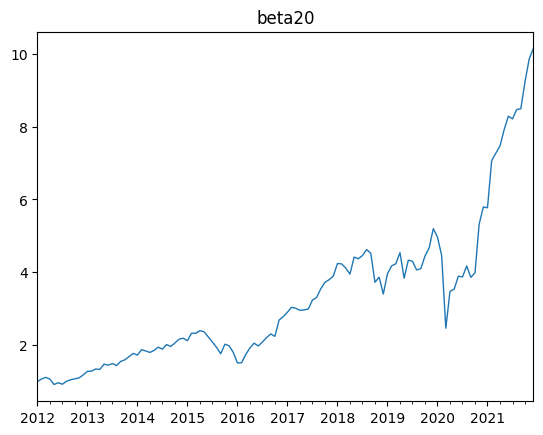

In [80]:
print((1 + top20_with_regime['beta20']).cumprod().plot(title='beta20', lw=1))
Metric(portfolio=(1 + top20_with_regime['beta20']).cumprod(), freq='month').print_report()

### beta20 with deflation

AxesSubplot(0.125,0.11;0.775x0.77)


returns            0.81
CAGR              -0.02
volatility         0.02
skewness          -0.46
kurtosis          22.03
MDD               -0.54
MDD_duration    2436.00
sharp             -2.73
sortino           -0.30
calmar            -0.04
VaR               -0.16
VaR_ratio          0.01
CVaR              -0.30
CVaR_ratio         0.00
hit                0.55
GtP                0.88
dtype: object

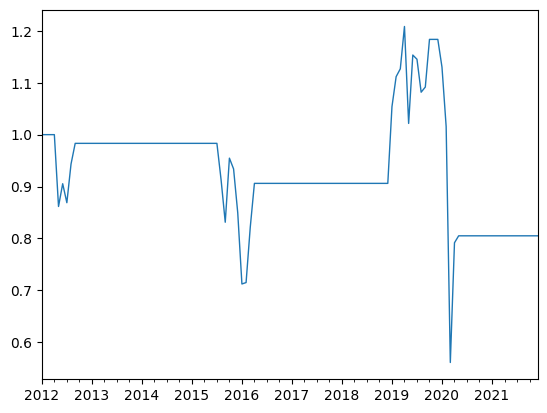

In [81]:
print((1 + top20_with_regime.beta20 * top20_with_regime.deflation).cumprod().plot(lw=1))
Metric(portfolio=(1 + top20_with_regime.beta20 * top20_with_regime.deflation).cumprod(), freq='month').numeric_metric(dict=False)

### beta20 with inflation

In [82]:
#(1 + top20_with_regime.beta20 * top20_with_regime.inflation).cumprod().plot(lw=1)
#Metric(portfolio=(1 + top20_with_regime.beta20 * top20_with_regime.inflation).cumprod(), freq='month').print_report()

CAGR: 0.00
CAGR: 0.00
Annualized Volatility: 0.00
Skewness: 0.00
Kurtosis: 0.00
Max Drawdown: 0.00%
Max Drawdown Duration: 0.00 days
Annualized Sharp Ratio: -inf
Annualized Sortino Ratio: -inf
Annualized Calmar Ratio: nan
Annualized VaR: 0.00
Annualized VaR Ratio: nan
Annualized CVaR: 0.00
Annualized CVaR Ratio: nan


/Users/jtchoi/Library/CloudStorage/GoogleDrive-jungtaek0227@gmail.com/My Drive/quant/Quant-Project/quant/backtest/metric.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  return (self.CAGR(returns) - yearly_rfr) / self.annualized_volatility(returns)
/Users/jtchoi/Library/CloudStorage/GoogleDrive-jungtaek0227@gmail.com/My Drive/quant/Quant-Project/quant/backtest/metric.py:159: RuntimeWarning: divide by zero encountered in scalar divide
  return (self.CAGR(returns) - yearly_rfr) / downside_std(returns)
/Users/jtchoi/Library/CloudStorage/GoogleDrive-jungtaek0227@gmail.com/My Drive/quant/Quant-Project/quant/backtest/metric.py:196: RuntimeWarning: invalid value encountered in scalar divide
  calmar = - self.CAGR(returns) / dd.min()
/Users/jtchoi/Library/CloudStorage/GoogleDrive-jungtaek0227@gmail.com/My Drive/quant/Quant-Project/quant/backtest/metric.py:228: RuntimeWarning: invalid value encountered in scalar divide
  ratio = -returns.mean() / self.VaR(returns, delta=del

ZeroDivisionError: division by zero

### beta20 with recovery

AxesSubplot(0.125,0.11;0.775x0.77)
CAGR: 0.16
CAGR: 0.16
Annualized Volatility: 0.01
Skewness: 4.33
Kurtosis: 26.59
Max Drawdown: -7.47%
Max Drawdown Duration: 365.00 days
Annualized Sharp Ratio: 8.40
Annualized Sortino Ratio: 4.04
Annualized Calmar Ratio: 2.09
Annualized VaR: -0.04
Annualized VaR Ratio: 0.31
Annualized CVaR: -0.06
Annualized CVaR Ratio: 0.22
Annualized hit Ratio: 0.76
Annualized GtP Ratio: 2.59


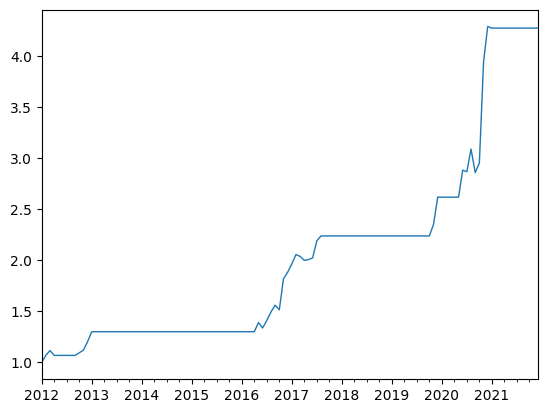

In [83]:
print((1 + top20_with_regime.beta20 * top20_with_regime.recovery).cumprod().plot(lw=1))
Metric(portfolio=(1 + top20_with_regime.beta20 * top20_with_regime.recovery).cumprod(), freq='month').print_report()

### beta20 with expansion

AxesSubplot(0.125,0.11;0.775x0.77)
CAGR: 0.10
CAGR: 0.10
Annualized Volatility: 0.01
Skewness: 3.75
Kurtosis: 19.79
Max Drawdown: -6.85%
Max Drawdown Duration: 1096.00 days
Annualized Sharp Ratio: 6.14
Annualized Sortino Ratio: 2.90
Annualized Calmar Ratio: 1.48
Annualized VaR: -0.03
Annualized VaR Ratio: 0.24
Annualized CVaR: -0.04
Annualized CVaR Ratio: 0.22
Annualized hit Ratio: 0.66
Annualized GtP Ratio: 2.80


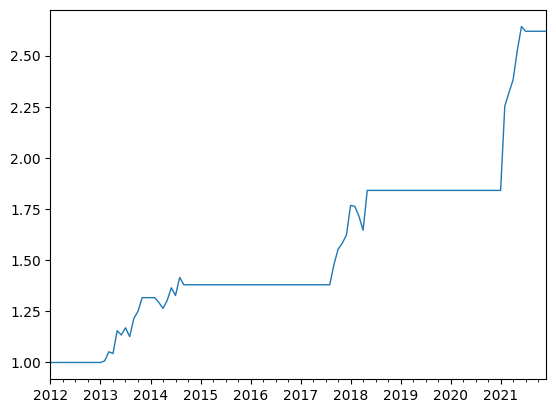

In [84]:
print((1 + top20_with_regime.beta20 * top20_with_regime.expansion).cumprod().plot(lw=1))
Metric(portfolio=(1 + top20_with_regime.beta20 * top20_with_regime.expansion).cumprod(), freq='month').print_report()

### 결론
- 베타 역시 확장국면과 획복국면에서 우상향하는 모습
- SPY 지수와 베타 팩터를 비교 후 시황포트폴리오의 성과지표 개선 여부를 확인해보자

### 자산군
    - 주식: sp500 index vs equity beta20
    - 장기채권: TLT ETF
    - 원자재: GSG ETF(tracking S&P GSCI index)
    - 달러: UUP index
    - 부동산: VNQ ETF

In [85]:
indexes_df = asset_indicators()
indexes_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,TLT,GSG,VNQ,UUP
1993-01-29,25.218231,NaN,NaN,NaN,NaN
1993-02-01,25.397581,NaN,NaN,NaN,NaN
1993-02-02,25.451399,NaN,NaN,NaN,NaN
1993-02-03,25.720428,NaN,NaN,NaN,NaN
1993-02-04,25.828043,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-02-06,409.829987,105.910004,20.129999,91.269997,27.950001
2023-02-07,415.190002,105.059998,20.590000,91.070000,27.900000
2023-02-08,410.649994,105.559998,20.680000,90.639999,27.930000
2023-02-09,407.089996,104.559998,20.530001,89.650002,27.889999


In [86]:
asset_ticker = ['SPY','TLT', 'GSG', 'VNQ', 'UUP']
asset_df = asset_indicators(asset_ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [88]:
asset_df = asset_df.loc['2012':,:].dropna().resample('M').last()
asset_df

,SPY,TLT,GSG,VNQ,UUP
2012-01-31,106.700020,92.835648,33.770000,40.016426,21.247902
2012-02-29,111.331360,90.424721,35.869999,39.555962,21.094210
2012-03-31,114.912224,86.594353,34.779999,41.612923,21.046183
2012-04-30,114.145096,90.780510,34.660000,42.802807,20.950125
2012-05-31,107.290024,98.973747,30.230000,40.874161,22.083603
...,...,...,...,...,...
2022-10-31,384.444611,95.170639,21.850000,81.823532,29.767994
2022-11-30,405.816467,101.976341,21.590000,86.852455,28.360384
2022-12-31,382.429993,99.304520,21.230000,82.480003,27.809999
2023-01-31,406.480011,106.894997,21.209999,91.059998,27.510000


In [89]:
ma_regime_df = pd.merge(asset_df.pct_change(), top20_with_regime, left_index=True, right_index=True, how='left').dropna()
ma_regime_df

multi_asset_tickers = ['SPY', 'beta20', 'TLT', 'GSG', 'VNQ', 'UUP']

In [90]:
ma_regime_df

,SPY,TLT,GSG,VNQ,UUP,beta20,deflation,inflation,recovery,expansion
2012-02-29,0.043405,-0.025970,0.062185,-0.011507,-0.007233,0.071178,0.0,0.0,1.0,0.0
2012-03-31,0.032164,-0.042360,-0.030388,0.052001,-0.002277,0.042314,0.0,0.0,1.0,0.0
2012-04-30,-0.006676,0.048342,-0.003450,0.028594,-0.004564,-0.042248,0.0,0.0,1.0,0.0
2012-05-31,-0.060056,0.090253,-0.127813,-0.045059,0.054104,-0.138476,1.0,0.0,0.0,0.0
2012-06-30,0.040581,-0.016782,0.006947,0.055171,-0.022619,0.050948,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.029760,-0.003402,-0.023926,0.021545,0.004845,0.031126,0.0,0.0,0.0,0.0
2021-09-30,-0.046605,-0.029070,0.059711,-0.056815,0.016874,0.002822,0.0,0.0,0.0,0.0
2021-10-31,0.070163,0.024650,0.058719,0.071330,-0.002371,0.087396,0.0,0.0,0.0,0.0
2021-11-30,-0.008035,0.027715,-0.105882,-0.021093,0.017822,0.067274,0.0,0.0,0.0,0.0


### 회복국면

AxesSubplot(0.125,0.11;0.775x0.77)
SPY
CAGR: 0.06
CAGR: 0.06
Annualized Volatility: 0.01
Skewness: 3.08
Kurtosis: 14.13
Max Drawdown: -6.14%
Max Drawdown Duration: 365.00 days
Annualized Sharp Ratio: 3.18
Annualized Sortino Ratio: 1.64
Annualized Calmar Ratio: 0.93
Annualized VaR: -0.02
Annualized VaR Ratio: 0.20
Annualized CVaR: -0.03
Annualized CVaR Ratio: 0.15
Annualized hit Ratio: 0.81
Annualized GtP Ratio: 1.37

beta20
CAGR: 0.15
CAGR: 0.15
Annualized Volatility: 0.01
Skewness: 4.43
Kurtosis: 27.43
Max Drawdown: -7.47%
Max Drawdown Duration: 365.00 days
Annualized Sharp Ratio: 7.92
Annualized Sortino Ratio: 3.81
Annualized Calmar Ratio: 2.01
Annualized VaR: -0.04
Annualized VaR Ratio: 0.30
Annualized CVaR: -0.06
Annualized CVaR Ratio: 0.21
Annualized hit Ratio: 0.75
Annualized GtP Ratio: 2.59

TLT
CAGR: -0.01
CAGR: -0.01
Annualized Volatility: 0.01
Skewness: -0.66
Kurtosis: 9.60
Max Drawdown: -16.08%
Max Drawdown Duration: 1979.00 days
Annualized Sharp Ratio: -10.25
Annualized Sor

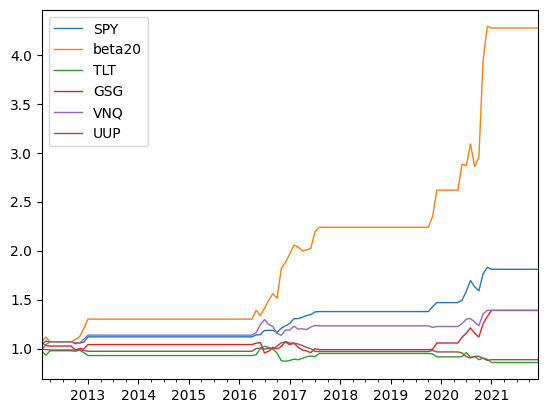

In [91]:
print((1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['recovery'], axis=0)).cumprod().plot(lw=1))

for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.recovery).cumprod(), freq='month').print_report()
    print()

### 확장국면

AxesSubplot(0.125,0.11;0.775x0.77)
SPY
CAGR: 0.06
CAGR: 0.06
Annualized Volatility: 0.00
Skewness: 1.41
Kurtosis: 3.52
Max Drawdown: -6.28%
Max Drawdown Duration: 1124.00 days
Annualized Sharp Ratio: 3.78
Annualized Sortino Ratio: 1.49
Annualized Calmar Ratio: 0.92
Annualized VaR: -0.03
Annualized VaR Ratio: 0.16
Annualized CVaR: -0.03
Annualized CVaR Ratio: 0.14
Annualized hit Ratio: 0.81
Annualized GtP Ratio: 1.21

beta20
CAGR: 0.10
CAGR: 0.10
Annualized Volatility: 0.01
Skewness: 3.73
Kurtosis: 19.60
Max Drawdown: -6.85%
Max Drawdown Duration: 1096.00 days
Annualized Sharp Ratio: 6.18
Annualized Sortino Ratio: 2.92
Annualized Calmar Ratio: 1.49
Annualized VaR: -0.04
Annualized VaR Ratio: 0.24
Annualized CVaR: -0.04
Annualized CVaR Ratio: 0.22
Annualized hit Ratio: 0.66
Annualized GtP Ratio: 2.80

TLT
CAGR: -0.01
CAGR: -0.01
Annualized Volatility: 0.00
Skewness: -0.79
Kurtosis: 6.42
Max Drawdown: -18.84%
Max Drawdown Duration: 3167.00 days
Annualized Sharp Ratio: -9.16
Annualized Sor

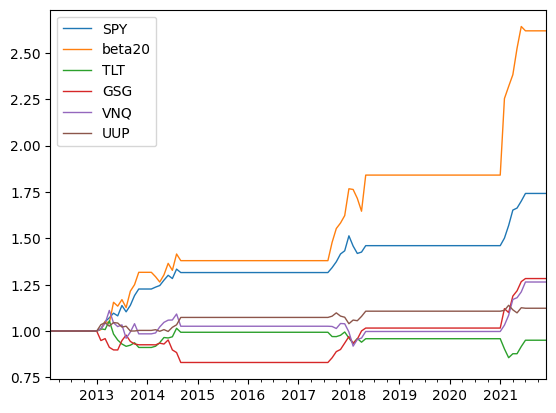

In [93]:
print((1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['expansion'], axis=0)).cumprod().plot(lw=1))

for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.expansion).cumprod(), freq='month').print_report()
    print()

### 인플레이션 국면

AxesSubplot(0.125,0.11;0.775x0.77)


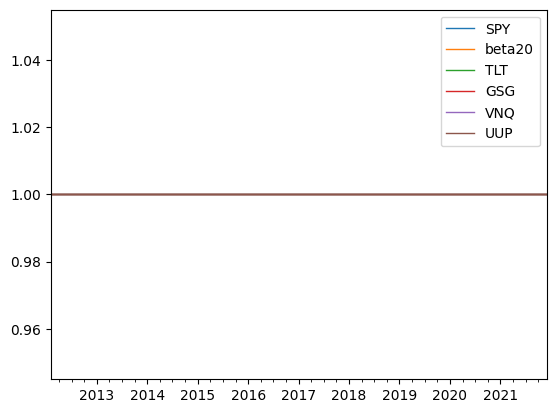

In [94]:
print((1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['inflation'], axis=0)).cumprod().plot(lw=1))

# for ticker in multi_asset_tickers:
#     print(ticker)
#     Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.inflation).cumprod(), freq='month').print_report()
#     print()

### 디플레이션 국면

AxesSubplot(0.125,0.11;0.775x0.77)
SPY
CAGR: 0.02
CAGR: 0.02
Annualized Volatility: 0.01
Skewness: 0.16
Kurtosis: 9.57
Max Drawdown: -19.45%
Max Drawdown Duration: 1249.00 days
Annualized Sharp Ratio: -2.39
Annualized Sortino Ratio: -0.17
Annualized Calmar Ratio: 0.10
Annualized VaR: -0.08
Annualized VaR Ratio: 0.03
Annualized CVaR: -0.10
Annualized CVaR Ratio: 0.02
Annualized hit Ratio: 0.62
Annualized GtP Ratio: 0.90

beta20
CAGR: -0.02
CAGR: -0.02
Annualized Volatility: 0.02
Skewness: -0.46
Kurtosis: 21.82
Max Drawdown: -53.59%
Max Drawdown Duration: 2436.00 days
Annualized Sharp Ratio: -2.71
Annualized Sortino Ratio: -0.30
Annualized Calmar Ratio: -0.04
Annualized VaR: -0.16
Annualized VaR Ratio: 0.01
Annualized CVaR: -0.30
Annualized CVaR Ratio: 0.00
Annualized hit Ratio: 0.55
Annualized GtP Ratio: 0.88

TLT
CAGR: 0.05
CAGR: 0.05
Annualized Volatility: 0.01
Skewness: 3.14
Kurtosis: 10.71
Max Drawdown: -4.48%
Max Drawdown Duration: 1248.00 days
Annualized Sharp Ratio: 1.87
Annualiz

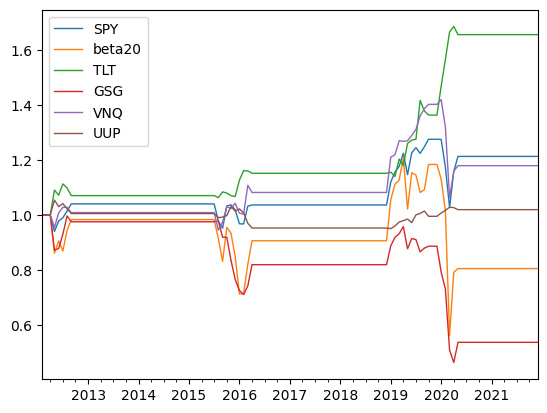

In [95]:
print((1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['deflation'], axis=0)).cumprod().plot(lw=1))

for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.deflation).cumprod(), freq='month').print_report()
    print()

### 결론
- 확장기와 회복기에 SPY 지수보다 좋은 성과를 보이는 베타 팩터
- 반대로 디플레이션 국면에서는 모든 지수를 하회하는 성과를 보였다

### SPY 지수를 대신해 베타 팩터를 사용한 시황포트폴리오를 만든 후 성과지표를 확인해보자

In [96]:
best_regime = pd.concat([
                        ma_regime_df.loc[(ma_regime_df.recovery == 1)]['beta20'], 
                        ma_regime_df.loc[(ma_regime_df.expansion == 1)]['beta20'],
                        ma_regime_df.loc[(ma_regime_df.deflation == 1)]['TLT'],
                        ma_regime_df.loc[(ma_regime_df.inflation == 1)]['UUP'],
                        ], ignore_index=False, axis=0)

best_regime

2012-02-29    0.071178
2012-03-31    0.042314
2012-04-30   -0.042248
2012-10-31    0.023385
2012-11-30    0.024326
                ...   
2020-01-31    0.076912
2020-02-29    0.066264
2020-03-31    0.063767
2020-04-30    0.012189
2020-05-31   -0.017619
Length: 94, dtype: float64

In [97]:
type(best_regime.index)
type(ma_regime_df.index)

best_regime.index = pd.to_datetime(best_regime.index)
best_regime.index

DatetimeIndex(['2012-02-29', '2012-03-31', '2012-04-30', '2012-10-31',
               '2012-11-30', '2012-12-31', '2013-01-31', '2016-05-31',
               '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30',
               '2016-10-31', '2016-11-30', '2016-12-31', '2017-01-31',
               '2017-02-28', '2017-03-31', '2017-04-30', '2017-05-31',
               '2017-06-30', '2017-07-31', '2017-08-31', '2019-11-30',
               '2019-12-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2014-03-31',
               '2014-04-30', '2014-05-31', '2014-06-30', '2014-07-31',
               '2014-08-31', '2014-09-30', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31', '2018-01-31', '2018-02-28',
      

In [98]:
not_explained = ma_regime_df.index.difference(best_regime.index)
not_explained

DatetimeIndex(['2013-12-31', '2014-01-31', '2014-02-28', '2014-10-31',
               '2014-11-30', '2014-12-31', '2015-01-31', '2015-02-28',
               '2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30',
               '2015-07-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2021-08-31', '2021-09-30', '2021-10-31', '2021-11-30',
               '2021-12-31'],
              dtype='datetime64[ns]', freq=None)

In [99]:
not_explained = ma_regime_df.index.difference(best_regime.index)
not_explained_df = pd.Series({'port_val':0}, index=not_explained)

In [100]:
total_regime = best_regime.append(not_explained_df).sort_index().fillna(0)

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_91986/2470937050.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_regime = best_regime.append(not_explained_df).sort_index().fillna(0)


AxesSubplot(0.125,0.11;0.775x0.77)
CAGR: 0.33
CAGR: 0.33
Annualized Volatility: 0.02
Skewness: 2.39
Kurtosis: 9.83
Max Drawdown: -7.47%
Max Drawdown Duration: 487.00 days
Annualized Sharp Ratio: 17.09
Annualized Sortino Ratio: 7.46
Annualized Calmar Ratio: 4.46
Annualized VaR: -0.04
Annualized VaR Ratio: 0.61
Annualized CVaR: -0.06
Annualized CVaR Ratio: 0.44
Annualized hit Ratio: 0.65
Annualized GtP Ratio: 3.20


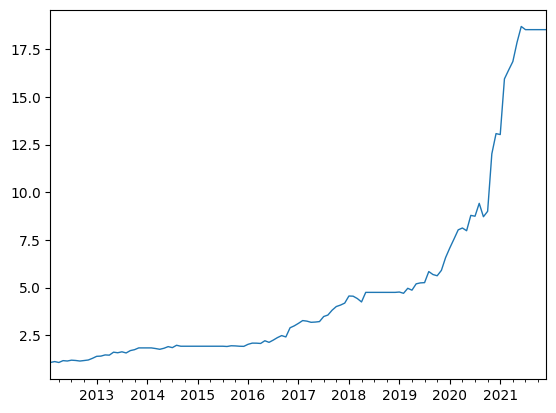

In [101]:
print((1 + total_regime).cumprod().plot(lw=1))
Metric(portfolio=(1 + total_regime).cumprod(), freq='month').print_report()

    - SPY지수를 포함한 시황포트폴리오의 성과지표
  
      Annualized Return: 18.60% 
      Annualized Volatility: 12.41%
      Skewness: 0.53
      Kurtosis: 2.98
      Max Drawdown: -17.13%
      Max Drawdown Duration: 487 days
      Annualized Sharp Ratio: 1.18
      Annualized Sortino Ratio: -0.39
      Annualized Calmar Ratio: 1.09
      Annualized VaR: -0.07
      Annualized VaR Ratio: 0.21
      Annualized CVaR: -0.11
      Annualized CVaR Ratio: 0.14
      Annualized hit Ratio: 0.70
      Annualized GtP Ratio: 1.63

### 결론
- SPY 지수 대신 베타 팩터를 사용한 경우 성과지표가 개선 되었다. 
- 연율화 수익률의 경우 약 14%포인트 상승
- 변동성은 약 6%포인트 상승
- 연율화 수익률의 상승이 변동성의 상승 폭을 상충시켜 샤프비율 역시 약 0.4 상승하였다.
- MDD 역시 -17.13%에서 -8.32%로 크게 개선되었다. 